# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy.sparse import csr_matrix, dia_matrix, csc_matrix, coo_matrix
from scipy import fftpack
import torch
from functools import reduce
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
import alens_analysis.read_func as arf
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

torch device: cuda


In [3]:
torch.__version__

import warnings

warnings.filterwarnings('ignore')

'1.13.0'

### Style settings

In [4]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

# Data generation

In [5]:
data_dir_list = {
cond_path /"22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations", 
cond_path /"22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations", 
cond_path /"22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations", 
cond_path /"22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations", 
cond_path /"22-11-23_aLchr1_scan8.12_line800_Ke50_Ls55nm_kod.1-300/simulations", 
cond_path /"22-11-23_aLchr1_scan8.12_line800_sticky20nm_kod3_Ke1-200/simulations", 
cond_path /"22-11-23_aLchr1_scan7.12_line800_sticky10-70nm_kod3_Ke5/simulations", 
cond_path /"22-11-23_aLchr1_scan8.12_line800_Ke10_Ls55nm_kod.1-300/simulations", 
}

running_dir_list = {
cond_path /"22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_2xLs.01-.07/simulations", 
cond_path /"22-12-08_aLc1_line800_Ke30_2xLs55nm_kod.1-300/simulations", 
cond_path /"22-12-08_aLchr1_scan8.12_line800_2xLs55nm_kod3_Ke1-200/simulations", 
cond_path /"22-12-07_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200/simulations", 
cond_path /"22-12-08_aLchr1_scan8.12_line800_Ls0.1-0.7_kod3_Ke1-200/simulations"
}

In [6]:
for pth in sorted(list(cond_path.glob("*/simulations"))):
    print(pth.relative_to(cond_path))

22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations
22-08-12_aLchr1_scan8.12_line800_sticky55nm_eps1_5um_Ke5-200/simulations
22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations
22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations
22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations
22-11-23_aLchr1_scan7.12_line800_sticky10-70nm_kod3_Ke5/simulations
22-11-23_aLchr1_scan8.12_line800_Ke10_Ls55nm_kod.1-300/simulations
22-11-23_aLchr1_scan8.12_line800_Ke50_Ls55nm_kod.1-300/simulations
22-11-23_aLchr1_scan8.12_line800_sticky20nm_kod3_Ke1-200/simulations
22-11-23_equil_scan.12_line800/simulations
22-12-07_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200/simulations
22-12-08_aLchr1_scan7.12_line800_Ke30_kod3.05_2xLs.01-.07/simulations
22-12-08_aLchr1_scan8.12_line800_2xLs55nm_kod3_Ke1-200/simulations
22-12-08_aLchr1_scan8.12_line800_Ke30_2xLs55nm_kod.1-300/simulations
22-12-08_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200/simulations
23-01-02_aLc1_

## Connection matrix

In [ ]:
def save_connect_data(run_path, param_str):
    anal_path = run_path / 'analysis'
    anal_path.mkdir(exist_ok=True)

    # Create an hdf5 file
    h5_path = anal_path / 'connect_run_data.h5'
    if h5_path.exists():
        h5_path.unlink()
    h5_file = h5py.File(h5_path, 'w')

    # Add label string as attribute
    h5_file.attrs['param'] = param_str

    sim_path = run_path / 'simulations'
    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in sim_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        for i, pd in tqdm(enumerate(param_dirs)):
            ac_arrs = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/connect_analysis.h5'):
                try:
                    sd_h5_data_lst += [h5py.File(h5p, 'r')]
                except:
                    print(f'Could not open {h5p}.')
                if len(sd_h5_data_lst) == 0:
                    print(f'No data files found for parameter directory {pd}')
                    continue
            for h5_data in sd_h5_data_lst:
                time_arr = h5_data['time'][...]
                ac_arrs += [h5_data['autocorr'][...]]

            for h5_data in sd_h5_data_lst:
                h5_data.close()

            min_length = min([_.size for _ in ac_arrs])
            ac_arrs = np.array([_[:min_length] for _ in ac_arrs])

            label = re.split(r'(^[^\d]+)', str(pd.name))[1:][1]
            data_arr = np.hstack((time_arr[:min_length][:,np.newaxis],
                                  ac_arrs.mean(axis=0)[:, np.newaxis],
                                  ac_arrs.std(axis=0)[:, np.newaxis]))
            d_set = h5_file.create_dataset(label, data=data_arr)
            d_set.attrs['seeds'] = ac_arrs.shape[0]

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


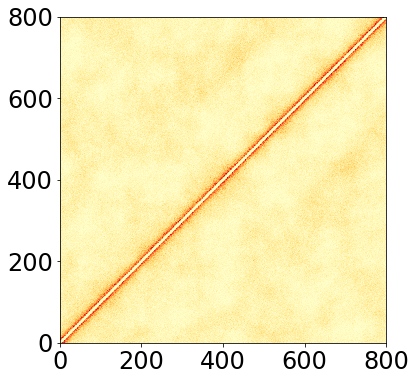

In [50]:
# data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30/s1"

# with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
#     time_arr = h5_data['time'][...]
#     prot_dat = h5_data['raw_data/proteins'][...]
#     connect_mat_list =[]
#     for i in range(time_arr.size):
#         connect_mat_list += [cps.get_connect_smat(prot_dat[:,:,i])]

#     avg_connect_mat = reduce(lambda x,y:x+y,connect_mat_list)
    
# fig, axarr = plt.subplots(1,1, figsize=(8, 6))

# mat = avg_connect_mat.toarray()
# axarr.set_aspect('equal')
# c = plt.pcolor(mat/time_arr.size)

In [26]:
tsnap_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/"
record_paths = [ 
                tsnap_path / 'kod0.1/s2',
                tsnap_path / 'kod0.3/s1',
                tsnap_path / 'kod1/s1',
                tsnap_path / 'kod10/s1',
                tsnap_path / 'kod30/s1',
                tsnap_path / 'kod300/s1',
                ]

In [10]:
# for data_path in tqdm(record_paths):
#     print(data_path)
#     with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
#         time_arr = h5_data['time'][...]
#         prot_dat = h5_data['raw_data/proteins'][...]
#         connect_mat_list =[]
#         for i in range(time_arr.size):
#             connect_mat_list += [get_connect_torch_smat(prot_dat[:,:,i])]

#     avg_connect_mat = reduce(lambda x,y:x+y,connect_mat_list)

#     with h5py.File(data_path / f'analysis/connect_{data_path.stem}.h5', 'w') as h5_cnct:
#         _ = h5_cnct.create_dataset('time', data=time_arr)
#         _ = h5_cnct.create_dataset('avg_connect_mat', data=avg_connect_mat.to_dense())
#         ac_arr = cps.connect_autocorr(connect_mat_list[:])
#         _ = h5_cnct.create_dataset('autocorr', data=ac_arr)

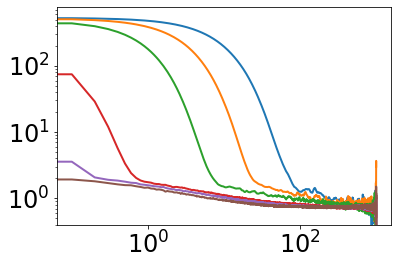

In [27]:
for data_path in record_paths:
    with h5py.File(next(data_path.glob('analysis/connect_analysis.h5')), 'r') as h5_data:
        time_arr = h5_data['time']
        ac_arr = h5_data['autocorr']
        _ = plt.plot(time_arr[:ac_arr.size], ac_arr)
        _ = plt.yscale('log')
        _ = plt.xscale('log')
        # _ = plt.xlim(.1, 10)
        _ = plt.ylim(.4)

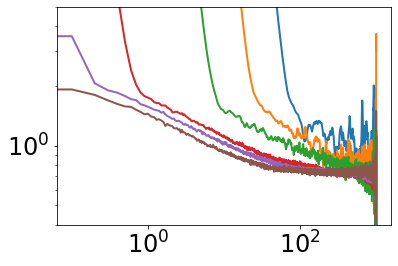

In [22]:
for data_path in record_paths:
    with h5py.File(next(data_path.glob('analysis/connect_analysis.h5')), 'r') as h5_data:
        time_arr = h5_data['time']
        ac_arr = h5_data['autocorr']
        _ = plt.plot(time_arr[:ac_arr.size], ac_arr)
        _ = plt.yscale('log')
        _ = plt.xscale('log')
        # _ = plt.xlim(.1, 10)
        _ = plt.ylim(.4, 5)

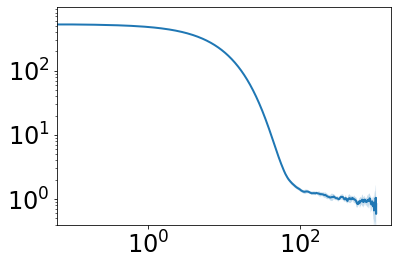

In [30]:
param_dir_path = tsnap_path / 'kod0.1'
ci_bound = .99
ac_arr_list = []
for h5_path in param_dir_path.glob('s*/analysis/connect_analysis.h5'): 
    with h5py.File(h5_path) as h5_data:
        time_arr = h5_data['time'][...]
        ac_arr_list += [h5_data['autocorr'][...]]

n_seeds = len(ac_arr_list)
ac_mean = np.array(ac_arr_list).mean(axis=0)
ci = ((np.array(ac_arr_list).std(axis=0)/np.sqrt(n_seeds)) *
        (np.sqrt(2)*erfinv(ci_bound)))
_ = plt.fill_between(time_arr, 
                    ac_mean - ci, ac_mean + ci, 
                    alpha=.25)
_ = plt.plot(time_arr, ac_mean)
_ = plt.yscale('log')
_ = plt.xscale('log')
# _ = plt.xlim(.1, 10)
_ = plt.ylim(.4)

In [8]:
# save_connect_data(cond_path / "23-01-02_alc1_line800_sticky55nm_kod.1-300_tsnap.1", 
#                    param_str="kod")
# save_connect_data(cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01", 
#                   param_str="kod")
# save_connect_data(cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001", 
#                   param_str="kod")
# save_connect_data(cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001", 
#                   param_str="kod")

In [68]:
def graph_connect_ac_ax(fig, ax, h5_path, 
                        colorbar_label='', 
                        ci_bound = .95,
                        label_str= '{}',
                        show_legend=True,
                        send_cut_ind = 2,
                        fend_cut_ind = -1,
                        ):
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
        log_pvs = np.log10([float(p) for p in param_vals])
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        for i, pv in enumerate(param_vals):
            h5_data = h5d[pv]
            time_arr = h5_data[send_cut_ind:fend_cut_ind,0]
            mean_ac_arr = h5_data[send_cut_ind:fend_cut_ind,1]
            std_ac_arr = h5_data[send_cut_ind:fend_cut_ind,2]

            _ = ax.plot(time_arr, mean_ac_arr,
                        color=colors[i], label=label_str.format(pv))
            ci = ((std_ac_arr/np.sqrt(h5_data.attrs['seeds'])) *
                  (np.sqrt(2)*erfinv(ci_bound)))
            _ = ax.fill_between(time_arr, 
                                mean_ac_arr - ci, mean_ac_arr + ci, 
                                color=colors[i], alpha=.25)

        # _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        _ = ax.set_ylabel('Connection autocorrelation\n' + r'$C_c$')
        _ = ax.set_xlabel(r'Lag time $\tau$ (sec)')
        _ = ax.set_xscale('log')
        _ = ax.set_yscale('log')
        # _ = ax.set_ylim(.09, 1)
        if show_legend:
            _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

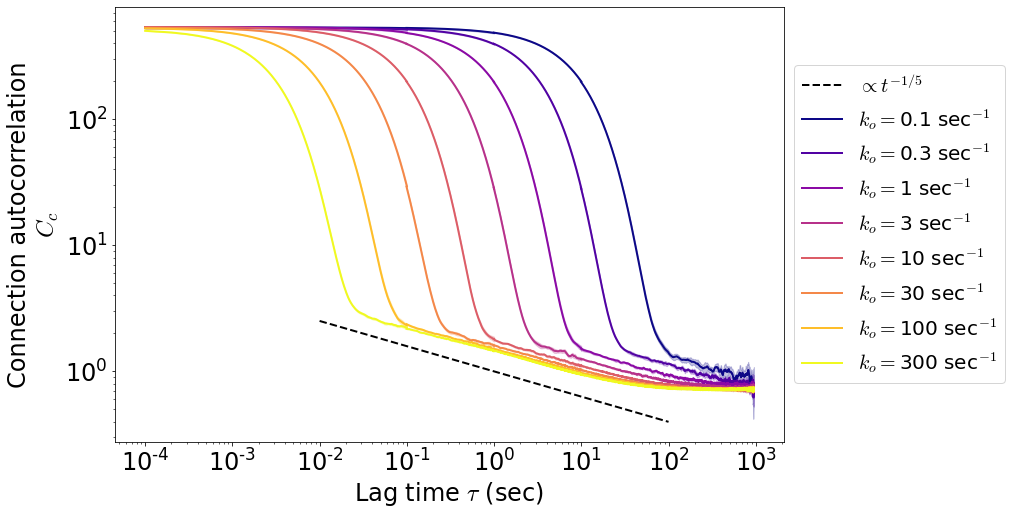

In [73]:
fig, axarr = plt.subplots(1,1, figsize=(12, 8))
x = np.linspace(.01,100)
y = np.power(x,-.2)
axarr.plot(x,y, linestyle='--', color='k', label=r'$\propto t^{-1/5}$')
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/connect_run_data.h5",
                    label_str='$k_o = ${} sec$^{{-1}}$',
                    show_legend=True, 
                    send_cut_ind=100, fend_cut_ind=-500)
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}',
                    show_legend=False, 
                    send_cut_ind = 100, fend_cut_ind = -9000)
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}',
                    show_legend=False, 
                    send_cut_ind = 100, fend_cut_ind = -9000)
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}',
                    show_legend=False, 
                    send_cut_ind = 2, fend_cut_ind = -9000)


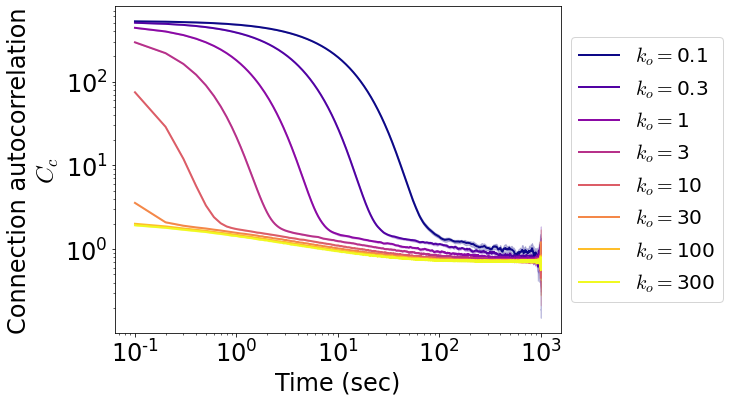

In [70]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}')


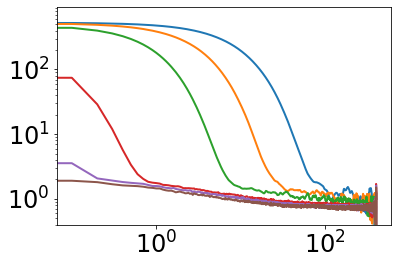

In [ ]:
records_path = cond_path / '23-05-27_aLc1_line800_sticky55nm_kod0-.03_tsnap.001_NB/simulations'
for data_path in record_paths.glob('ko*'):
    with h5py.File(next(data_path.glob('analysis/Connect*.h5')), 'r') as h5_data:
        time_arr = h5_data['time']
        ac_arr = h5_data['autocorr']
        _ = plt.plot(time_arr[:ac_arr.size], ac_arr)
        _ = plt.yscale('log')
        _ = plt.xscale('log')
        # _ = plt.xlim(.1, 10)
        _ = plt.ylim(.4)

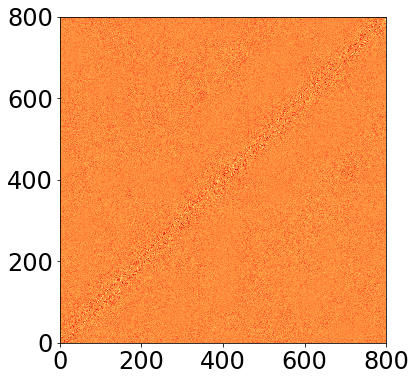

In [40]:

fig, axarr = plt.subplots(1,1, figsize=(8, 6))

# mat = avg_sparse_mat.toarray()
avg_mat = mat/time_arr.size
axarr.set_aspect('equal')
c = axarr.pcolor(avg_mat - avg_mat.T)

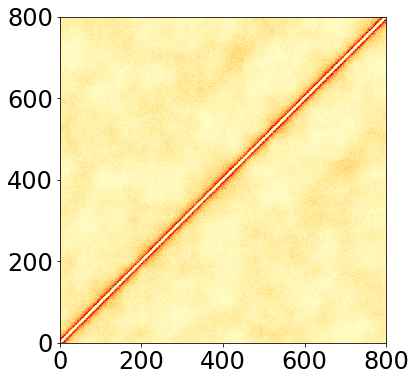

In [41]:

fig, axarr = plt.subplots(1,1, figsize=(8, 6))

# mat = avg_sparse_mat.toarray()
avg_mat = mat/time_arr.size
axarr.set_aspect('equal')
c = axarr.pcolor(.5 *(avg_mat + avg_mat.T))

In [ ]:
data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30/s1"

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    nlinks = prot_dat.shape[0]

    xlinks = (prot_dat[:,-1,-1] >= 0)
    xlink_coords = prot_dat[xlinks][:,-2:, -1].astype(int)
    data = np.ones((xlink_coords.shape[0]))
    sparse_mat1 = coo_matrix((data,(xlink_coords[:,0],xlink_coords[:,1])),shape=[nlinks,nlinks])

# Fractal connection analysis

In [28]:
data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod1/s1"

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    bead_num = h5_data['raw_data/sylinders'][...].shape[0]
    print(bead_num)
    connect_mat_list = []
    for i in range(1, time_arr.shape[0], 10):
        print(i)
        connect_mat_list.append(cps.get_connect_torch_smat(prot_dat[:,:,i], bead_num))
    auto_corr = cps.connect_section_autocorr(connect_mat_list, [10,60])
    # connect_smat = cps.get_connect_torch_smat(prot_dat[:,:,-100], bead_num)
    # print(connect_smat.to_dense())
    print(auto_corr)



800
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621
631
641
651
661
671
681
691
701
711
721
731
741
751
761
771
781
791
801
811
821
831
841
851
861
871
881
891
901
911
921
931
941
951
961
971
981
991
1001
1011
1021
1031
1041
1051
1061
1071
1081
1091
1101
1111
1121
1131
1141
1151
1161
1171
1181
1191
1201
1211
1221
1231
1241
1251
1261
1271
1281
1291
1301
1311
1321
1331
1341
1351
1361
1371
1381
1391
1401
1411
1421
1431
1441
1451
1461
1471
1481
1491
1501
1511
1521
1531
1541
1551
1561
1571
1581
1591
1601
1611
1621
1631
1641
1651
1661
1671
1681
1691
1701
1711
1721
1731
1741
1751
1761
1771
1781
1791
1801
1811
1821
1831
1841
1851
1861
1871
1881
1891
1901
1911
1921
1931
1941
1951
1961
1971
1981
1991
2001
2011
2021
2031
2041
2051
2061
2071
2081
2091
2101
2111
2121
2131
2141
2151
2161
2171
2181
2191
2201
22

(0.01, 1.0)

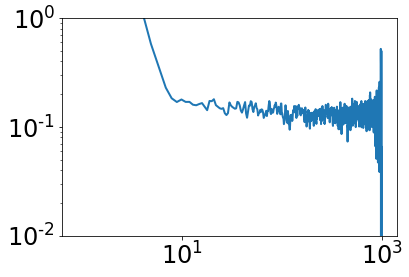

In [31]:
plt.plot(time_arr[::10], auto_corr)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2, 1e0)

In [12]:
data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod1/s1"

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    bead_num = h5_data['raw_data/sylinders'][...].shape[0]
    print(bead_num)
    connect_mat_list = []
    for i in range(1, time_arr.shape[0], 10):
        print(i)
        connect_mat_list.append(cps.get_connect_torch_smat(prot_dat[:,:,i], bead_num))
    auto_corr = cps.connect_diag_autocorr(connect_mat_list)
    # connect_smat = cps.get_connect_torch_smat(prot_dat[:,:,-100], bead_num)
    # print(connect_smat.to_dense())
    print(auto_corr)


800
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621
631
641
651
661
671
681
691
701
711
721
731
741
751
761
771
781
791
801
811
821
831
841
851
861
871
881
891
901
911
921
931
941
951
961
971
981
991
1001
1011
1021
1031
1041
1051
1061
1071
1081
1091
1101
1111
1121
1131
1141
1151
1161
1171
1181
1191
1201
1211
1221
1231
1241
1251
1261
1271
1281
1291
1301
1311
1321
1331
1341
1351
1361
1371
1381
1391
1401
1411
1421
1431
1441
1451
1461
1471
1481
1491
1501
1511
1521
1531
1541
1551
1561
1571
1581
1591
1601
1611
1621
1631
1641
1651
1661
1671
1681
1691
1701
1711
1721
1731
1741
1751
1761
1771
1781
1791
1801
1811
1821
1831
1841
1851
1861
1871
1881
1891
1901
1911
1921
1931
1941
1951
1961
1971
1981
1991
2001
2011
2021
2031
2041
2051
2061
2071
2081
2091
2101
2111
2121
2131
2141
2151
2161
2171
2181
2191
2201
22

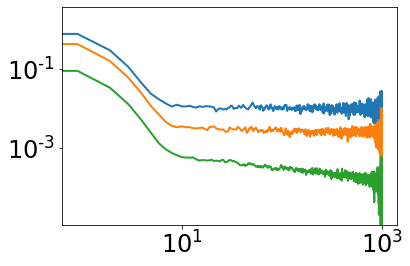

In [23]:
plt.plot(time_arr[::10], auto_corr[:,:10].sum(axis=1)/auto_corr[0,:10].size)
plt.plot(time_arr[::10], auto_corr[:,10:60].sum(axis=1)/auto_corr[0,10:60].size)
plt.plot(time_arr[::10], auto_corr[:,60:].sum(axis=1)/auto_corr[0,60:].size)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e-2, 1e0)

In [8]:
data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.3/s1/analysis"

with h5py.File(next(data_path.glob('raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    bead_num = h5_data['raw_data/sylinders'][...].shape[0]
    print(bead_num)
    connect_mat_list = []
    for i in range(1, time_arr.shape[0], 100):
        connect_mat_list.append(cps.get_connect_torch_smat(prot_dat[:,:,i], bead_num))
    print(len(connect_mat_list))
    auto_corr_kod_03 = cps.connect_diag_autocorr(connect_mat_list)
    # connect_smat = cps.get_connect_torch_smat(prot_dat[:,:,-100], bead_num)
    # print(connect_smat.to_dense())



800
101


In [26]:
data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.3/s1/analysis/raw_tmp.h5"

ca.create_connect_hdf5(data_path, force=True, verbose=True)




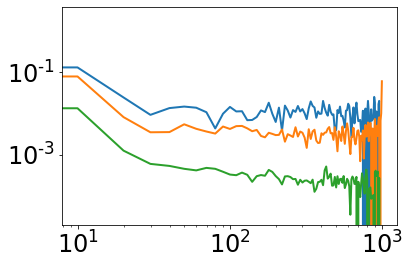

In [28]:
with h5py.File(data_path.parent / f'connect_diag_analysis.h5', 'r') as h5_cnct:
    time_arr = h5_cnct['time'][...]
    ac = h5_cnct['autocorr'][...]

plt.plot(time_arr[:], ac[:,:10].sum(axis=1)   /  ac[0,:10].size)
plt.plot(time_arr[:], ac[:,10:60].sum(axis=1) /  ac[0,10:60].size)
plt.plot(time_arr[:], ac[:,60:].sum(axis=1)   /  ac[0,60:].size)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e-2, 1e0)

(0.01, 1.0)

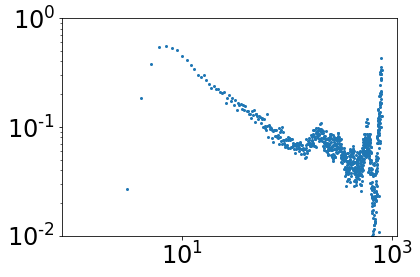

In [34]:
with h5py.File(data_path.parent / f'connect_diag_analysis.h5', 'r') as h5_cnct:
    time_arr = h5_cnct['time'][...]
    acm = h5_cnct['avg_connect_mat'][...]

    avg_connect_vs_ind = torch.zeros(acm.shape[0])
    for i in range(1, acm.shape[0]):
        avg_connect_vs_ind[i] += acm.diagonal(i).mean()
        avg_connect_vs_ind[i] += acm.diagonal(-i).mean()
        avg_connect_vs_ind[i] *= .5


plt.scatter(range(1,acm.shape[0]), avg_connect_vs_ind[1:])
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2, 1e0)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


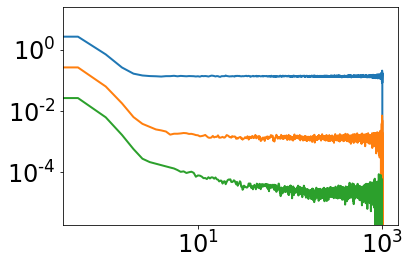

In [7]:
data_path = cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.02/s1/analysis/connect_diag_analysis.h5"

with h5py.File(data_path, 'r') as h5_cnct:
    time_arr = h5_cnct['lag_time'][...]
    ac = h5_cnct['autocorr'][...]

plt.plot(time_arr[:], ac[:,:10].sum(axis=1)   /  ac[0,:10].size)
plt.plot(time_arr[:], ac[:,10:60].sum(axis=1) /  ac[0,10:60].size)
plt.plot(time_arr[:], ac[:,60:].sum(axis=1)   /  ac[0,60:].size)
plt.xscale('log')
plt.yscale('log')

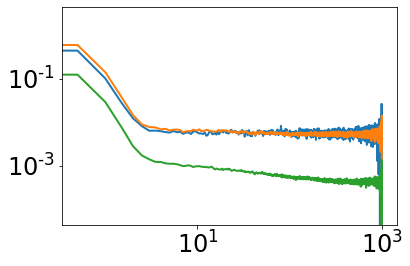

In [ ]:
data_path = cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.07/s1/analysis/connect_diag_analysis.h5"

with h5py.File(data_path, 'r') as h5_cnct:
    time_arr = h5_cnct['lag_time'][...]
    ac = h5_cnct['autocorr'][...]

plt.plot(time_arr[:], ac[:,:10].sum(axis=1)   /  ac[0,:10].size)
plt.plot(time_arr[:], ac[:,10:60].sum(axis=1) /  ac[0,10:60].size)
plt.plot(time_arr[:], ac[:,60:].sum(axis=1)   /  ac[0,60:].size)
plt.xscale('log')
plt.yscale('log')

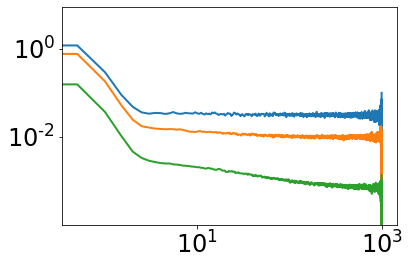

In [12]:
data_path = cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke200/s1/analysis/connect_diag_analysis.h5"

with h5py.File(data_path, 'r') as h5_cnct:
    time_arr = h5_cnct['lag_time'][...]
    ac = h5_cnct['autocorr'][...]

plt.plot(time_arr[:], ac[:,:10].sum(axis=1)   /  ac[0,:10].size)
plt.plot(time_arr[:], ac[:,10:60].sum(axis=1) /  ac[0,10:60].size)
plt.plot(time_arr[:], ac[:,60:].sum(axis=1)   /  ac[0,60:].size)
plt.xscale('log')
plt.yscale('log')

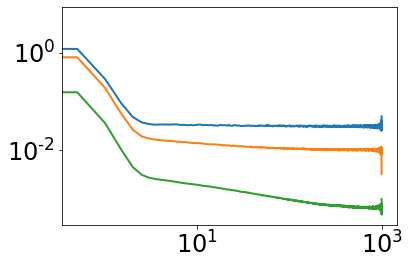

In [15]:
data_path = cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke200/"

ac_list = []
for dp in data_path.glob('s*/analysis/connect_diag_analysis.h5'):

    with h5py.File(dp, 'r') as h5_cnct:
        time_arr = h5_cnct['lag_time'][...]
        ac_list += [h5_cnct['autocorr'][...]]
    
ac = np.array(ac_list).mean(axis=0)

plt.plot(time_arr[:], ac[:,:10].sum(axis=1)   /  ac[0,:10].size)
plt.plot(time_arr[:], ac[:,10:60].sum(axis=1) /  ac[0,10:60].size)
plt.plot(time_arr[:], ac[:,60:].sum(axis=1)   /  ac[0,60:].size)
plt.xscale('log')
plt.yscale('log')

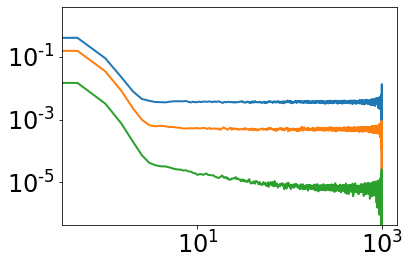

In [16]:
data_path = cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5/"

ac_list = []
for dp in data_path.glob('s*/analysis/connect_diag_analysis.h5'):

    with h5py.File(dp, 'r') as h5_cnct:
        time_arr = h5_cnct['lag_time'][...]
        ac_list += [h5_cnct['autocorr'][...]]
    
ac = np.array(ac_list).mean(axis=0)

plt.plot(time_arr[:], ac[:,:10].sum(axis=1)   /  ac[0,:10].size)
plt.plot(time_arr[:], ac[:,10:60].sum(axis=1) /  ac[0,10:60].size)
plt.plot(time_arr[:], ac[:,60:].sum(axis=1)   /  ac[0,60:].size)
plt.xscale('log')
plt.yscale('log')

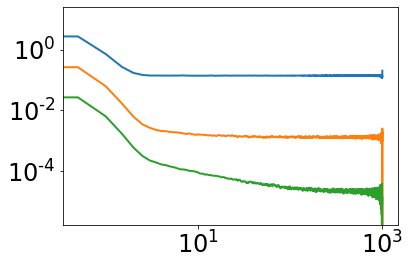

In [17]:
data_path = cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.02/"

ac_list = []
for dp in data_path.glob('s*/analysis/connect_diag_analysis.h5'):

    with h5py.File(dp, 'r') as h5_cnct:
        time_arr = h5_cnct['lag_time'][...]
        ac_list += [h5_cnct['autocorr'][...]]
    
ac = np.array(ac_list).mean(axis=0)

plt.plot(time_arr[:], ac[:,:10].sum(axis=1)   /  ac[0,:10].size)
plt.plot(time_arr[:], ac[:,10:60].sum(axis=1) /  ac[0,10:60].size)
plt.plot(time_arr[:], ac[:,60:].sum(axis=1)   /  ac[0,60:].size)
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, 'Connection correlation')

Text(0.5, 0, 'Lag time [sec]')

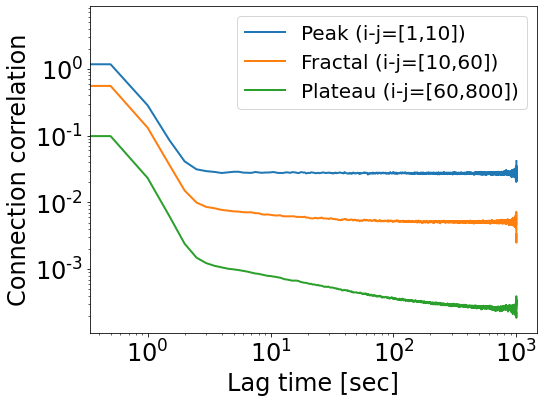

In [55]:
data_path = cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.05/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))


ac_list = []
for dp in data_path.glob('s*/analysis/connect_diag_analysis.h5'):

    with h5py.File(dp, 'r') as h5_cnct:
        time_arr = h5_cnct['lag_time'][...]
        ac_list += [h5_cnct['autocorr'][...]]
    
ac = np.array(ac_list).mean(axis=0)

axarr.plot(time_arr[:], ac[:,:10].mean(axis=1)   , label='Peak (i-j=[1,10])')
axarr.plot(time_arr[:], ac[:,10:60].mean(axis=1) , label='Fractal (i-j=[10,60])')
axarr.plot(time_arr[:], ac[:,60:].mean(axis=1)   , label='Plateau (i-j=[60,800])')
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('Connection correlation')
axarr.set_xlabel('Lag time [sec]')
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr.legend(loc='best')


Text(0, 0.5, 'Connection correlation')

Text(0.5, 0, 'Lag time [sec]')

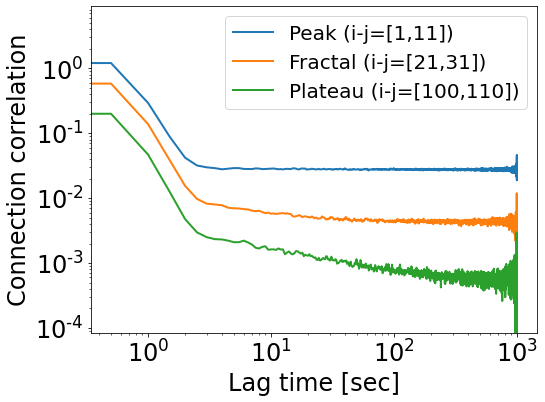

In [53]:
data_path = cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.05/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))


ac_list = []
for dp in data_path.glob('s*/analysis/connect_diag_analysis.h5'):

    with h5py.File(dp, 'r') as h5_cnct:
        time_arr = h5_cnct['lag_time'][...]
        ac_list += [h5_cnct['autocorr'][...]]
    
ac = np.array(ac_list).mean(axis=0)

_ = axarr.plot(time_arr[:], ac[:,:11].mean(axis=1)   , label='Peak (i-j=[1,11])')
_ = axarr.plot(time_arr[:], ac[:,21:31].mean(axis=1) , label='Fractal (i-j=[21,31])')
_ = axarr.plot(time_arr[:], ac[:,100:110].mean(axis=1)   , label='Plateau (i-j=[100,110])')
_ = axarr.set_xscale('log')
_ = axarr.set_yscale('log')
_ = axarr.set_ylabel('Connection correlation')
_ = axarr.set_xlabel('Lag time [sec]')
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr.legend(loc='best')


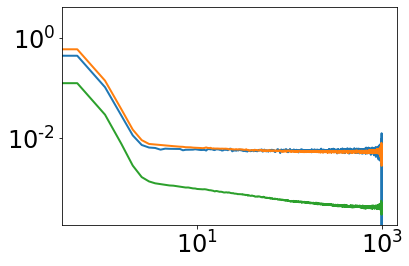

In [54]:
data_path = cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.07/"

ac_list = []
for dp in data_path.glob('s*/analysis/connect_diag_analysis.h5'):

    with h5py.File(dp, 'r') as h5_cnct:
        time_arr = h5_cnct['lag_time'][...]
        ac_list += [h5_cnct['autocorr'][...]]
    
ac = np.array(ac_list).mean(axis=0)

plt.plot(time_arr[:], ac[:,:10].sum(axis=1)   /  ac[0,:10].size)
plt.plot(time_arr[:], ac[:,10:60].sum(axis=1) /  ac[0,10:60].size)
plt.plot(time_arr[:], ac[:,60:].sum(axis=1)   /  ac[0,60:].size)
plt.xscale('log')
plt.yscale('log')

# Crosslink ratio

In [ ]:
def save_slice_crosslink_ratio_data(run_path,
                    param_str_list, 
                    ss_rog_avg_start_ind=-600,
                    ss_ind = 1,
                    end_ind = -1,
                    start_bead = 0,
                    end_bead = None,
                  ):
    # Make analysis directory if it doesn't exist
    anal_path = (run_path / 'analysis')
    anal_path.mkdir(exist_ok=True)


    # Create an hdf5 file
    h5_path = anal_path / 'crosslink_slice_data.h5'
    if h5_path.exists():
        h5_path.unlink()
    h5_file = h5py.File(h5_path, 'w')

    # Add label string as attribute
    h5_file.attrs['params'] = param_str_list

    sim_path = run_path / 'simulations'
    try:
        mp = re.compile(f'{param_str_list[0]}(\d*\.?\d+)_{param_str_list[1]}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in sim_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        for i, pd in tqdm(enumerate(param_dirs)):
            rog_arrs = []
            clps_times = []
            avg_clps_rog_arr = []
            std_clps_rog_arr = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst += [h5py.File(h5p, 'r')]
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                print(f'No data files found for parameter directory {pd}')
                continue

            for h5_data in sd_h5_data_lst:
                # Get data from seed h5 file
                time_arr = h5_data['time'][ss_ind:end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                          :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

                rog = aa.calc_rad_of_gyration(com_arr)
                clps_ind = ahlp.find_steady_state_ind(
                    rog, [ss_rog_avg_start_ind, None])
                rog_arrs += [rog.tolist()]
                clps_times += [time_arr[clps_ind]]
                avg_clps_rog_arr += [rog[clps_ind:].mean()]
                std_clps_rog_arr += [rog[clps_ind:].std()]

            for h5d in sd_h5_data_lst:
                h5d.close()

            # Make sure the runs are all the same length
            min_length = min([len(_) for _ in rog_arrs])
            rog_arrs = np.array([_[:min_length] for _ in rog_arrs])

            # Create dataset
            match = mp.match(pd.name)
            pvals = [match[1], match[2]]
            data_arr = np.hstack((time_arr[:min_length][:,np.newaxis],
                                  rog_arrs.mean(axis=0)[:, np.newaxis],
                                  rog_arrs.std(axis=0)[:, np.newaxis]))
            print(data_arr.shape)
            d_set = h5_file.create_dataset(pd.name, data=data_arr)
            d_set.attrs[param_str_list[0]] = pvals[0]
            d_set.attrs[param_str_list[1]] = pvals[1] 
            d_set.attrs['seeds'] = rog_arrs.shape[0]
            d_set.attrs['collapse_times'] = clps_times
            d_set.attrs['avg_collapse_rog'] = avg_clps_rog_arr
            d_set.attrs['std_collapse_rog'] = std_clps_rog_arr

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            

            for h5d in sd_h5_data_lst:
                h5d.close()

# Testing

In [ ]:
prot_dat_path = Path("/dev/shm/2xLs55nm_omp2/result/result0-399/ProteinAscii_1.dat")
syl_dat_path = Path("/dev/shm/2xLs55nm_omp2/result/result0-399/SylinderAscii_1.dat")
prots = arf.read_dat_xlp(prot_dat_path)
syls = [fil.get_dat()
            for fil in arf.read_dat_sylinder(syl_dat_path) 
            if (fil.fil_type != 'L')]
print(prots[0].get_dat())
# print(syls[50].gid)
print(len(syls))
n_beads = len(syls)


In [ ]:

connect_mat = np.zeros((n_beads, n_beads))
for prot in prots:
    end0, end1 = map(int, prot.get_dat()[-2:])
    if end0 < 0 or end1 < 0:
        continue
    connect_mat[end0, end1] += 1
    # For undirected connections, make matrix symmetric
    connect_mat[end1, end0] = connect_mat[end0, end1]
    


In [ ]:

from scipy.sparse import csc_matrix
csc_connect = csc_matrix((n_beads, n_beads))
for prot in prots:
    end0, end1 = map(int, prot.get_dat()[-2:])
    if end0 < 0 or end1 < 0:
        continue
    csc_connect[end0, end1] += 1
    # For undirected connections, make matrix symmetric
    csc_connect[end1, end0] = csc_connect[end0, end1]
plt.pcolor(csc_connect.toarray())
import scipy
scipy.__version__